In [3]:
!pip install lightgbm

1. 자전거 데이터에서 "casual" (즉흥적인 회원 대여수), "registered" (일상 회원 대여수)를 
y로 예측하는 Linear regression, LGBM 모델을 각각 만들고 예측 성능을 비교하세요.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 584, number of used features: 14
[LightGBM] [Info] Start training from score 820.258562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

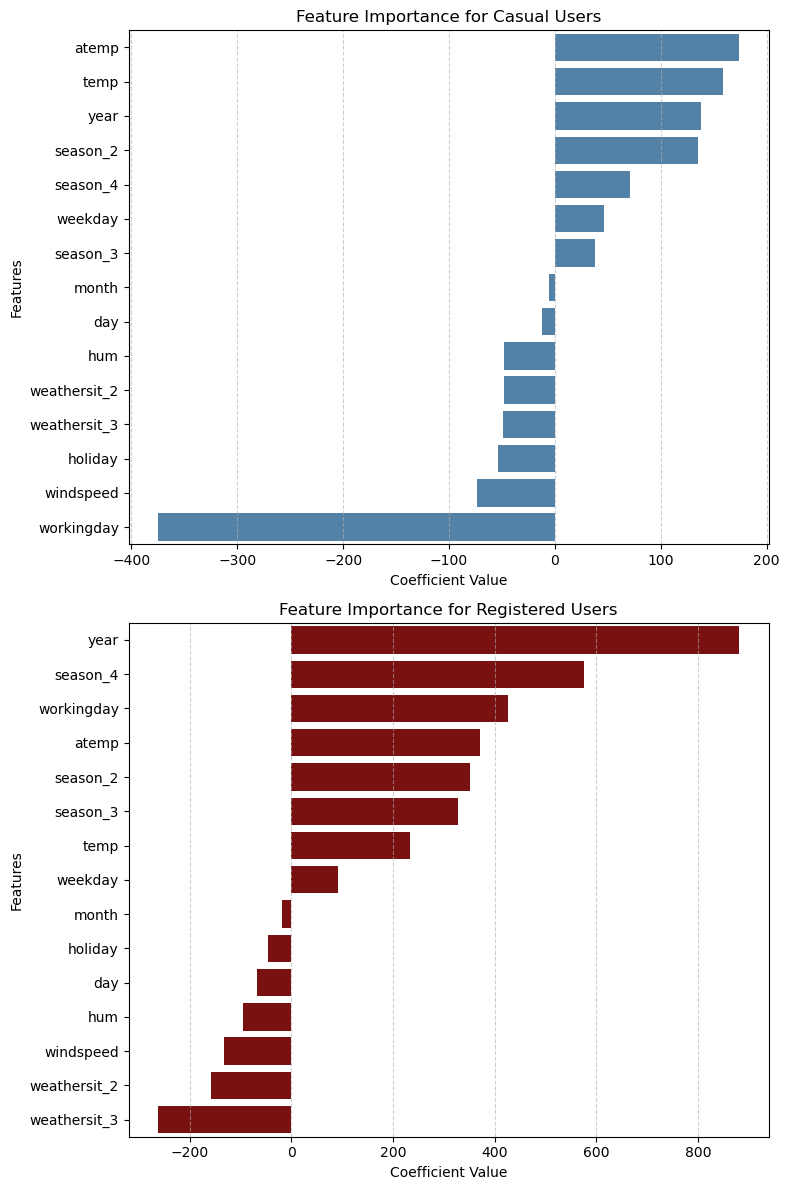

        Model  R2 Score
0      Casual  0.696995
1  Registered  0.833079
atemp           174.375856
temp            158.473773
year            137.876043
season_2        135.425237
season_4         70.779687
weekday          46.187378
season_3         37.921232
month            -5.935847
day             -12.527523
hum             -47.893847
weathersit_2    -48.193921
weathersit_3    -49.155534
holiday         -53.331091
windspeed       -73.672127
workingday     -375.144670
dtype: float64
year            881.956318
season_4        575.492892
workingday      426.334773
atemp           371.028721
season_2        350.849160
season_3        327.082614
temp            233.896465
weekday          92.023345
month           -17.864433
holiday         -45.763750
day             -67.243186
hum             -95.786993
windspeed      -133.529491
weathersit_2   -159.411739
weathersit_3   -263.320825
dtype: float64


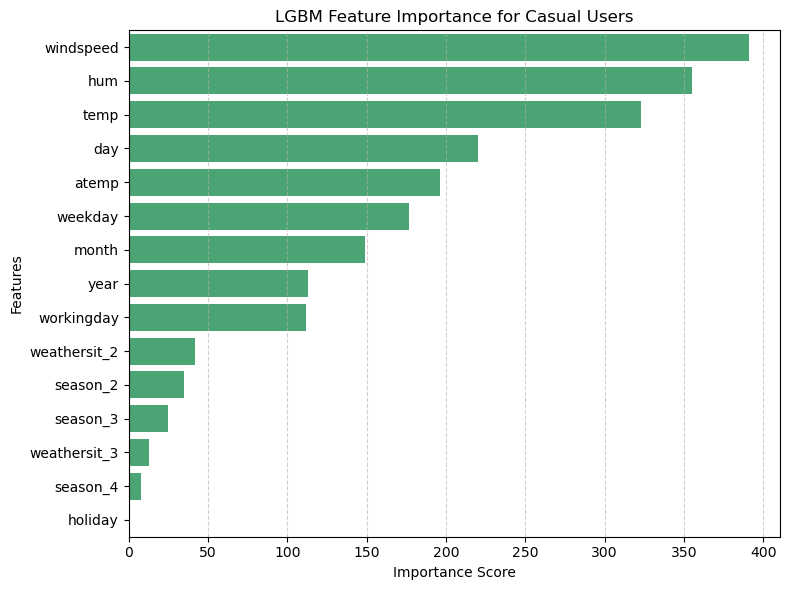

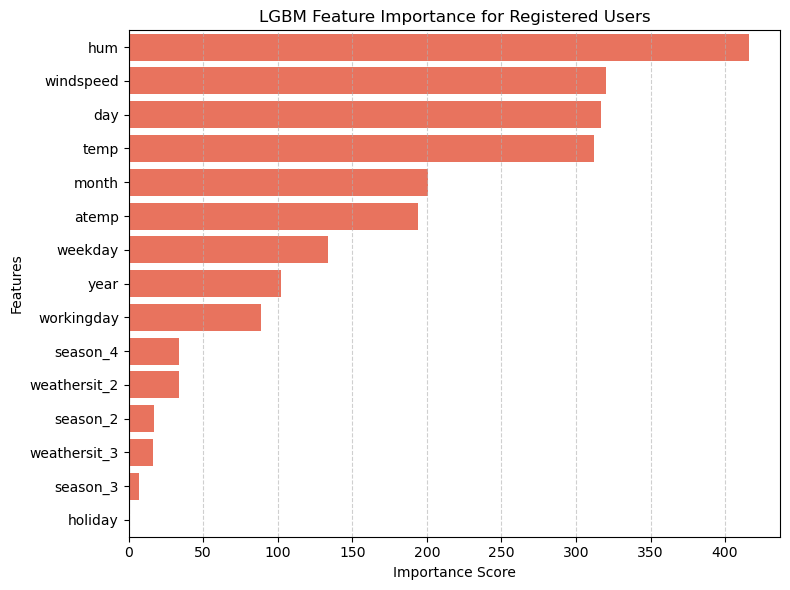

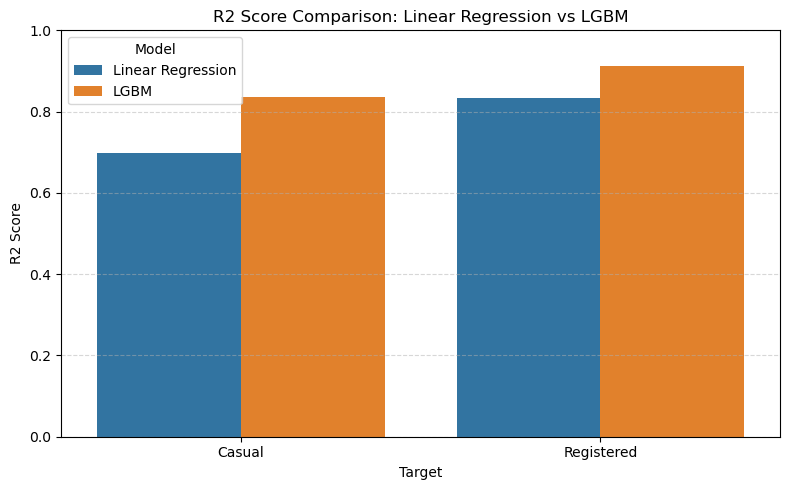

,Target,Model,R2 Score
0,Casual,Linear Regression,0.696995
1,Casual,LGBM,0.836301
2,Registered,Linear Regression,0.833079
3,Registered,LGBM,0.912489


In [5]:
# 필요한 라이브러리 다시 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor

# 파일 재업로드 필요
file_path = r"C:\001. Python\700. 설명가능인공지능_실습\bike-sharing-daily.csv"

# 데이터 로드
df_bike = pd.read_csv(file_path, engine="python", encoding="utf-8")

# 날짜 데이터 처리 (연, 월, 일 분리)
df_bike["dteday"] = pd.to_datetime(df_bike["dteday"])
df_bike["year"] = df_bike["dteday"].dt.year
df_bike["month"] = df_bike["dteday"].dt.month
df_bike["day"] = df_bike["dteday"].dt.day

# 불필요한 원래 날짜 컬럼 삭제
df_bike.drop(columns=["dteday", "instant"], inplace=True)

# 범주형 변수 인코딩 (one-hot encoding)
df_bike = pd.get_dummies(df_bike, columns=['season', 'weathersit'], drop_first=True)

# 다중 공선성을 방지하기 위해 'yr', 'mnth' 제거 (연도는 'year', 월은 'month' 사용)
df_bike.drop(columns=["yr", "mnth"], inplace=True)

# 독립변수 X 설정
x_bike = df_bike.drop(columns=['casual', 'registered', 'cnt'])

# 데이터 스케일링 (표준화)
scaler = StandardScaler()
x_bike_scaled = pd.DataFrame(scaler.fit_transform(x_bike), columns=x_bike.columns)

# casual (즉흥적 대여) 예측 모델
y_casual = df_bike['casual']
x_train_casual, x_test_casual, y_train_casual, y_test_casual = train_test_split(x_bike_scaled, y_casual, test_size=0.2, random_state=10)

lr_casual = LinearRegression()
lr_casual.fit(x_train_casual, y_train_casual)
pred_casual = lr_casual.predict(x_test_casual)
r2_casual = r2_score(y_test_casual, pred_casual)

coef_casual = pd.Series(lr_casual.coef_, index=x_bike_scaled.columns).sort_values(ascending=False)

# registered (등록된 회원 대여) 예측 모델
y_registered = df_bike['registered']
x_train_registered, x_test_registered, y_train_registered, y_test_registered = train_test_split(x_bike_scaled, y_registered, test_size=0.2, random_state=10)

lr_registered = LinearRegression()
lr_registered.fit(x_train_registered, y_train_registered)
pred_registered = lr_registered.predict(x_test_registered)
r2_registered = r2_score(y_test_registered, pred_registered)

coef_registered = pd.Series(lr_registered.coef_, index=x_bike_scaled.columns).sort_values(ascending=False)

# ----------- LGBM 모델 학습 및 평가 -----------

# casual 예측 - LGBM
lgbm_casual = LGBMRegressor(random_state=10)
lgbm_casual.fit(x_train_casual, y_train_casual)
pred_lgbm_casual = lgbm_casual.predict(x_test_casual)
r2_lgbm_casual = r2_score(y_test_casual, pred_lgbm_casual)

# registered 예측 - LGBM
lgbm_registered = LGBMRegressor(random_state=10)
lgbm_registered.fit(x_train_registered, y_train_registered)
pred_lgbm_registered = lgbm_registered.predict(x_test_registered)
r2_lgbm_registered = r2_score(y_test_registered, pred_lgbm_registered)

# 모델 성능 비교
r2_results = pd.DataFrame({
    "Model": ["Casual", "Registered"],
    "R2 Score": [r2_casual, r2_registered]
})

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

sns.barplot(x=coef_casual.values, y=coef_casual.index, ax=axes[0], color="steelblue")
axes[0].set_title("Feature Importance for Casual Users")
axes[0].set_xlabel("Coefficient Value")
axes[0].set_ylabel("Features")
axes[0].grid(axis='x', linestyle="--", alpha=0.6)

sns.barplot(x=coef_registered.values, y=coef_registered.index, ax=axes[1], color="darkred")
axes[1].set_title("Feature Importance for Registered Users")
axes[1].set_xlabel("Coefficient Value")
axes[1].set_ylabel("Features")
axes[1].grid(axis='x', linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

# 결과 출력 (모델 성능 및 회귀 계수)
# season은 1 (Winter), 2 (Spring), 3 (Summer), 4 (Fall), weathersit는 1 (Good), 2 (Misty), 3(Rain/Snow/Storm)
print(r2_results)
print(coef_casual)
print(coef_registered)

# ----------- LGBM Feature Importance 시각화 -----------

# Feature Importance (Casual)
lgbm_casual_importance = pd.Series(lgbm_casual.feature_importances_, index=x_bike_scaled.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=lgbm_casual_importance.values, y=lgbm_casual_importance.index, color='mediumseagreen')
plt.title("LGBM Feature Importance for Casual Users")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Feature Importance (Registered)
lgbm_registered_importance = pd.Series(lgbm_registered.feature_importances_, index=x_bike_scaled.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=lgbm_registered_importance.values, y=lgbm_registered_importance.index, color='tomato')
plt.title("LGBM Feature Importance for Registered Users")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# ----------- 성능 비교 -----------

r2_comparison = pd.DataFrame({
    "Target": ["Casual", "Casual", "Registered", "Registered"],
    "Model": ["Linear Regression", "LGBM", "Linear Regression", "LGBM"],
    "R2 Score": [r2_casual, r2_lgbm_casual, r2_registered, r2_lgbm_registered]
})

# ----------- 시각화 -----------

plt.figure(figsize=(8, 5))
sns.barplot(data=r2_comparison, x="Target", y="R2 Score", hue="Model")
plt.title("R2 Score Comparison: Linear Regression vs LGBM")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# ----------- 결과 출력 -----------

r2_comparison



2. 1에서 만들어진 "casual", "registered" 각각을 예측 하는 Linear regression, LGBM 모델 결과를 해석하여 (LR은 coefficient 해석, LGBM은 SHAP 방법으로 해석) 예측에 가장 큰 영향을 미치는 독립변수는 무엇인지 비교하세요.

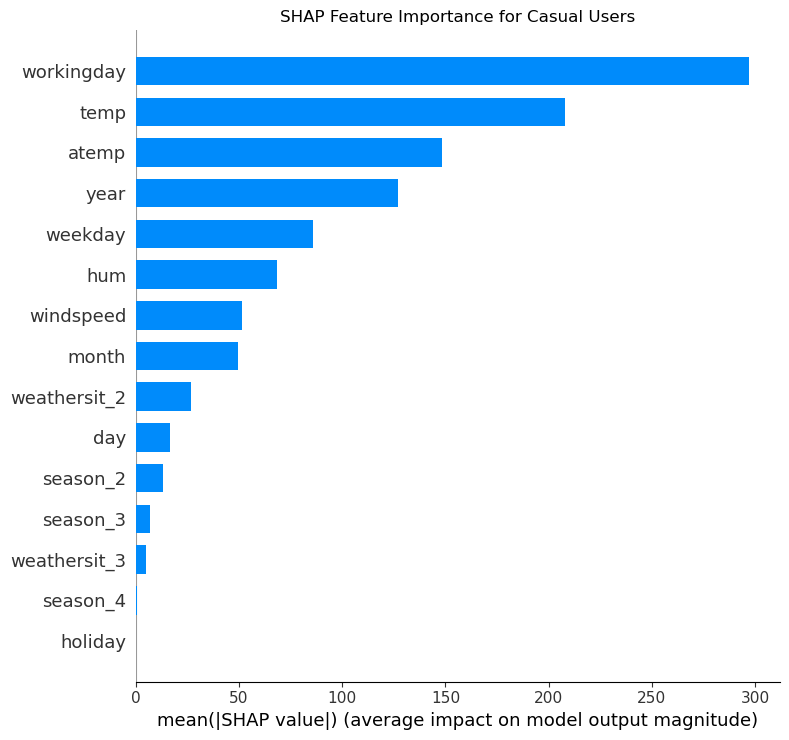

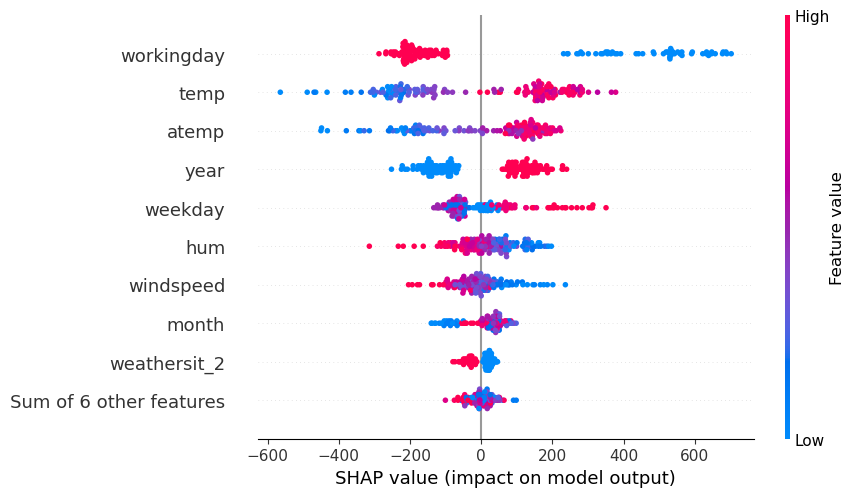

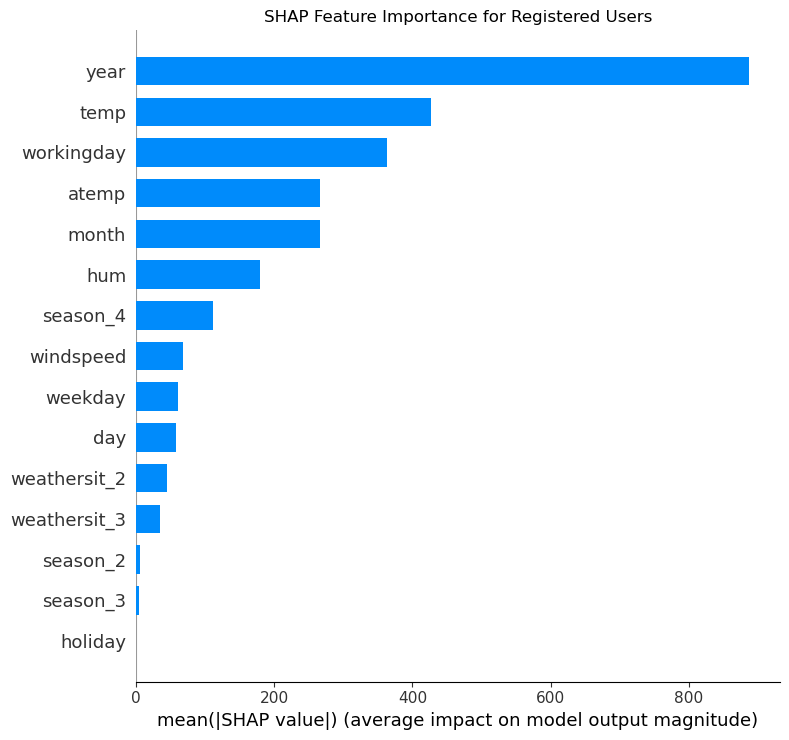

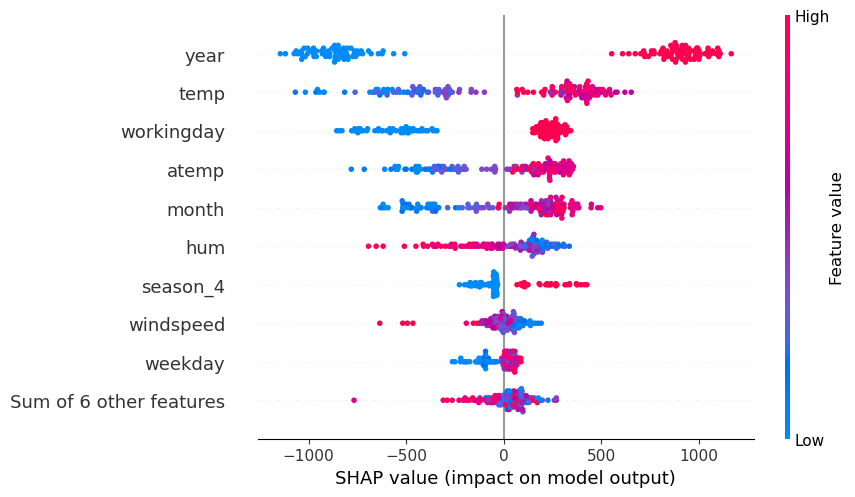

(atemp       174.375856
 temp        158.473773
 year        137.876043
 season_2    135.425237
 season_4     70.779687
 dtype: float64,
 year          881.956318
 season_4      575.492892
 workingday    426.334773
 atemp         371.028721
 season_2      350.849160
 dtype: float64)

In [14]:
import shap

# SHAP 값 계산
explainer_casual = shap.Explainer(lgbm_casual)
shap_values_casual = explainer_casual(x_test_casual)

explainer_registered = shap.Explainer(lgbm_registered)
shap_values_registered = explainer_registered(x_test_registered)

# SHAP Summary Plot
shap.summary_plot(shap_values_casual, x_test_casual, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for Casual Users")
plt.tight_layout()
plt.show()

explainer = shap.TreeExplainer(lgbm_casual)
shap_values = explainer(x_test_casual) # SHAP values for casual users
shap.plots.beeswarm(shap_values)

shap.summary_plot(shap_values_registered, x_test_registered, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for Registered Users")
plt.tight_layout()
plt.show()

explainer = shap.TreeExplainer(lgbm_registered)
shap_values = explainer(x_test_registered) # SHAP values for casual users
shap.plots.beeswarm(shap_values)

# coef_casual, coef_registered는 이미 계산되어 있음
coef_casual.head(5), coef_registered.head(5)

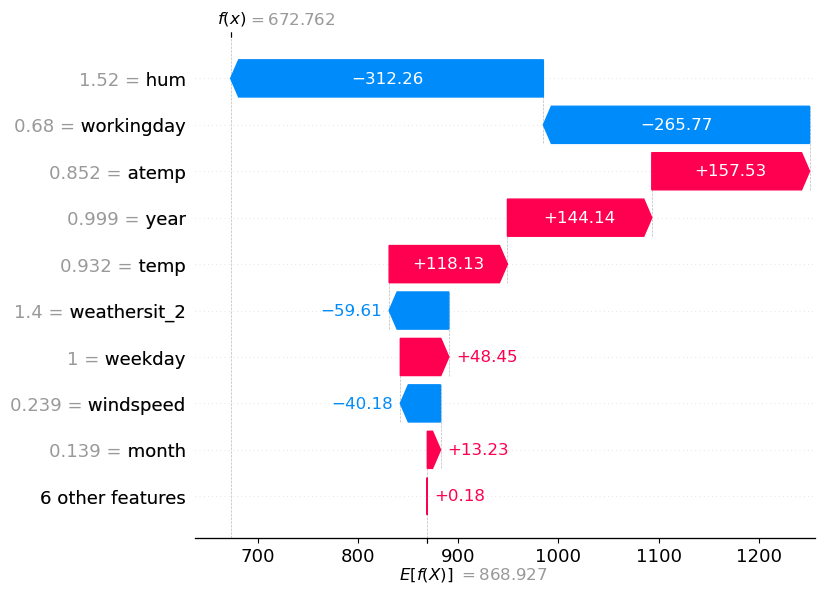

In [23]:
import shap

# ---------------------------------------------------------
# 1. casual 사용자 예측 모델 (LGBM) - SHAP 값 계산
# ---------------------------------------------------------
explainer_casual = shap.Explainer(lgbm_casual, x_train_casual)
shap_values_casual = explainer_casual(x_test_casual)

# Waterfall plot - 첫 번째 샘플 해석
shap.plots.waterfall(shap_values_casual[0])


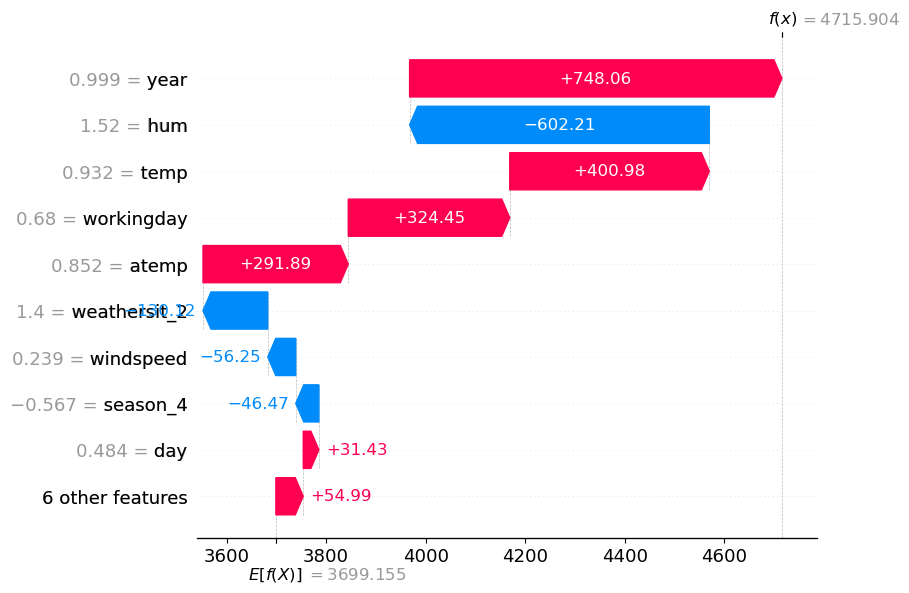

In [24]:
# ---------------------------------------------------------
# 2. registered 사용자 예측 모델 (LGBM) - SHAP 값 계산
# ---------------------------------------------------------
explainer_registered = shap.Explainer(lgbm_registered, x_train_registered)
shap_values_registered = explainer_registered(x_test_registered)

# Waterfall plot - 첫 번째 샘플 해석
shap.plots.waterfall(shap_values_registered[0])


3. Cancer 데이터에서 10-30대, 40-60대 에 따라 자궁암 여부를 예측하는 Logistic regression, LGBM 모델을 만들고 예측 성능을 비교하세요.

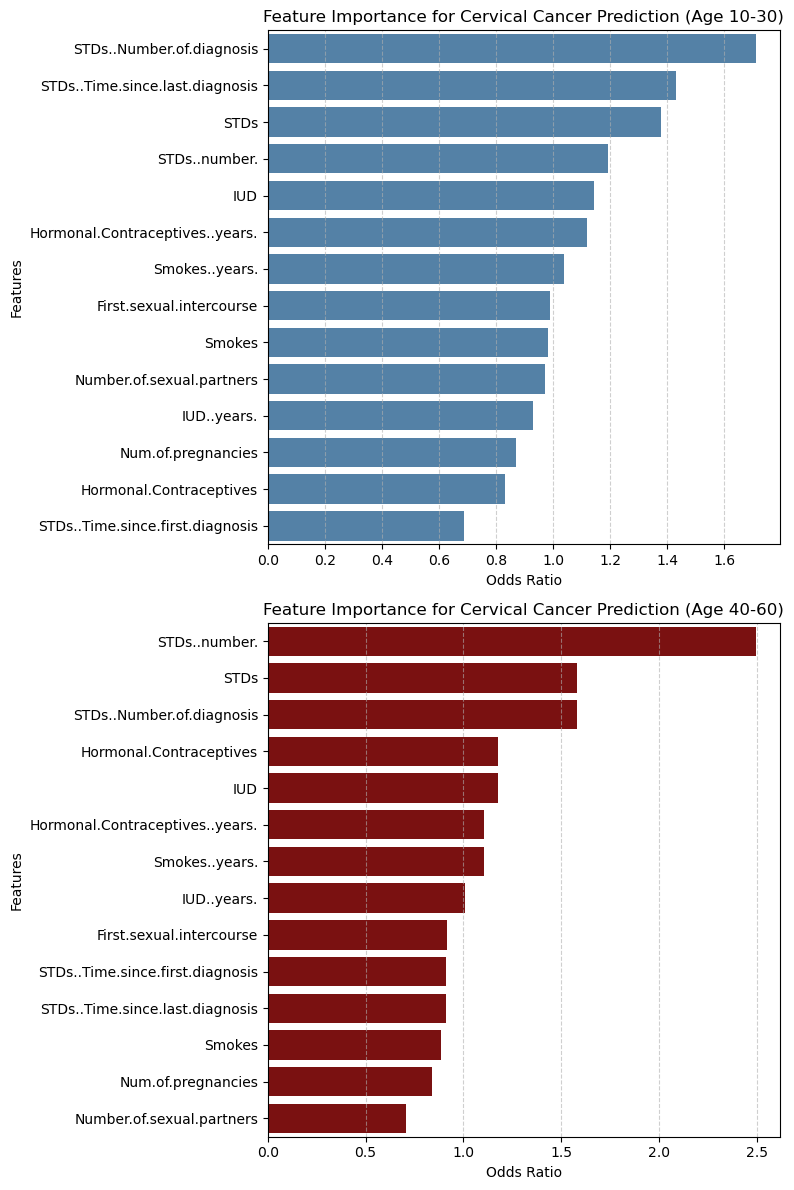

[LightGBM] [Info] Number of positive: 36, number of negative: 598
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 131
[LightGBM] [Info] Number of data points in the train set: 634, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.056782 -> initscore=-2.810072
[LightGBM] [Info] Start training from score -2.810072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


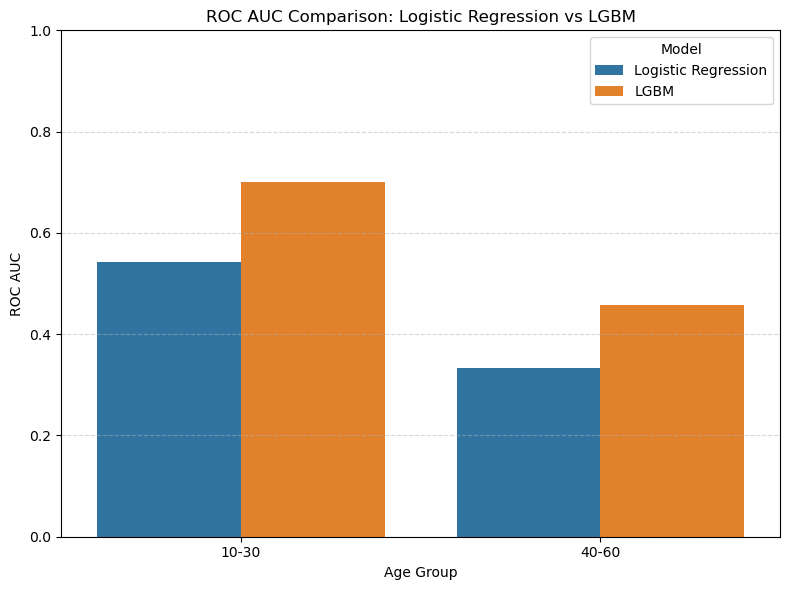

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from lightgbm import LGBMClassifier


# 파일 재업로드 필요
file_path = r"C:\001. Python\700. 설명가능인공지능_실습\cancer.csv"

# 데이터 로드
df_cancer = pd.read_csv(file_path, engine="python", encoding="utf-8")

# 연령대를 정확하게 10대, 20대, 30대 / 40대, 50대, 60대로 구분
df_cancer["Age_Group"] = pd.cut(
    df_cancer["Age"],
    bins=[10, 19, 29, 39, 49, 59, 69],  # 연령 구간 정의
    labels=["10대", "20대", "30대", "40대", "50대", "60대"]  # 각 연령대에 대한 라벨 지정
)

# 10-30대 (10대, 20대, 30대) 데이터 필터링
df_cancer_10_30 = df_cancer[df_cancer["Age_Group"].isin(["10대", "20대", "30대"])].drop(columns=["Age", "Age_Group"])

# 40-60대 (40대, 50대, 60대) 데이터 필터링
df_cancer_40_60 = df_cancer[df_cancer["Age_Group"].isin(["40대", "50대", "60대"])].drop(columns=["Age", "Age_Group"])

# 독립변수(X)와 종속변수(y) 설정
X_10_30 = df_cancer_10_30.drop(columns=["Biopsy"])  # 자궁암 여부 (Biopsy) 제외
y_10_30 = df_cancer_10_30["Biopsy"]

X_40_60 = df_cancer_40_60.drop(columns=["Biopsy"])
y_40_60 = df_cancer_40_60["Biopsy"]

# 데이터 분할 (훈련/테스트 세트)
X_train_10_30, X_test_10_30, y_train_10_30, y_test_10_30 = train_test_split(X_10_30, y_10_30, test_size=0.2, random_state=42)
X_train_40_60, X_test_40_60, y_train_40_60, y_test_40_60 = train_test_split(X_40_60, y_40_60, test_size=0.2, random_state=42)

# 로지스틱 회귀 모델 생성 및 학습
logit_10_30 = LogisticRegression(max_iter=1000)
logit_40_60 = LogisticRegression(max_iter=1000)

logit_10_30.fit(X_train_10_30, y_train_10_30)
logit_40_60.fit(X_train_40_60, y_train_40_60)

# 예측 수행
y_pred_10_30 = logit_10_30.predict(X_test_10_30)
y_pred_40_60 = logit_40_60.predict(X_test_40_60)

# 모델 성능 평가
accuracy_10_30 = accuracy_score(y_test_10_30, y_pred_10_30)
accuracy_40_60 = accuracy_score(y_test_40_60, y_pred_40_60)

roc_auc_10_30 = roc_auc_score(y_test_10_30, logit_10_30.predict_proba(X_test_10_30)[:, 1])
roc_auc_40_60 = roc_auc_score(y_test_40_60, logit_40_60.predict_proba(X_test_40_60)[:, 1])

# 모델 성능 결과 저장
model_results = pd.DataFrame({
    "Age Group": ["10-30", "40-60"],
    "Accuracy": [accuracy_10_30, accuracy_40_60],
    "ROC AUC": [roc_auc_10_30, roc_auc_40_60]
})

# 회귀 계수 (Odds Ratio) 계산
coef_10_30 = pd.Series(np.exp(logit_10_30.coef_[0]), index=X_10_30.columns).sort_values(ascending=False)
coef_40_60 = pd.Series(np.exp(logit_40_60.coef_[0]), index=X_40_60.columns).sort_values(ascending=False)

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

# 10-30대 Feature Importance
sns.barplot(x=coef_10_30.values, y=coef_10_30.index, ax=axes[0], color="steelblue")
axes[0].set_title("Feature Importance for Cervical Cancer Prediction (Age 10-30)")
axes[0].set_xlabel("Odds Ratio")
axes[0].set_ylabel("Features")
axes[0].grid(axis='x', linestyle="--", alpha=0.6)

# 40-60대 Feature Importance
sns.barplot(x=coef_40_60.values, y=coef_40_60.index, ax=axes[1], color="darkred")
axes[1].set_title("Feature Importance for Cervical Cancer Prediction (Age 40-60)")
axes[1].set_xlabel("Odds Ratio")
axes[1].set_ylabel("Features")
axes[1].grid(axis='x', linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

# 결과 출력 (모델 성능 및 회귀 계수)
model_results, coef_10_30, coef_40_60

# ----------- LGBM 모델 생성 및 학습 -----------

# 10-30대
lgbm_10_30 = LGBMClassifier(random_state=42)
lgbm_10_30.fit(X_train_10_30, y_train_10_30)

# 40-60대
lgbm_40_60 = LGBMClassifier(random_state=42)
lgbm_40_60.fit(X_train_40_60, y_train_40_60)

# ----------- 예측 및 평가 -----------

# 10-30대
y_pred_lgbm_10_30 = lgbm_10_30.predict(X_test_10_30)
accuracy_lgbm_10_30 = accuracy_score(y_test_10_30, y_pred_lgbm_10_30)
roc_auc_lgbm_10_30 = roc_auc_score(y_test_10_30, lgbm_10_30.predict_proba(X_test_10_30)[:, 1])

# 40-60대
y_pred_lgbm_40_60 = lgbm_40_60.predict(X_test_40_60)
accuracy_lgbm_40_60 = accuracy_score(y_test_40_60, y_pred_lgbm_40_60)
roc_auc_lgbm_40_60 = roc_auc_score(y_test_40_60, lgbm_40_60.predict_proba(X_test_40_60)[:, 1])

# ----------- 성능 결과 비교 -----------

lgbm_results = pd.DataFrame({
    "Age Group": ["10-30", "40-60"],
    "Accuracy": [accuracy_lgbm_10_30, accuracy_lgbm_40_60],
    "ROC AUC": [roc_auc_lgbm_10_30, roc_auc_lgbm_40_60]
})

# 두 모델 비교
comparison = pd.concat([
    model_results.assign(Model="Logistic Regression"),
    lgbm_results.assign(Model="LGBM")
])

# ----------- 시각화 -----------

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(data=comparison, x="Age Group", y="ROC AUC", hue="Model")
plt.title("ROC AUC Comparison: Logistic Regression vs LGBM")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


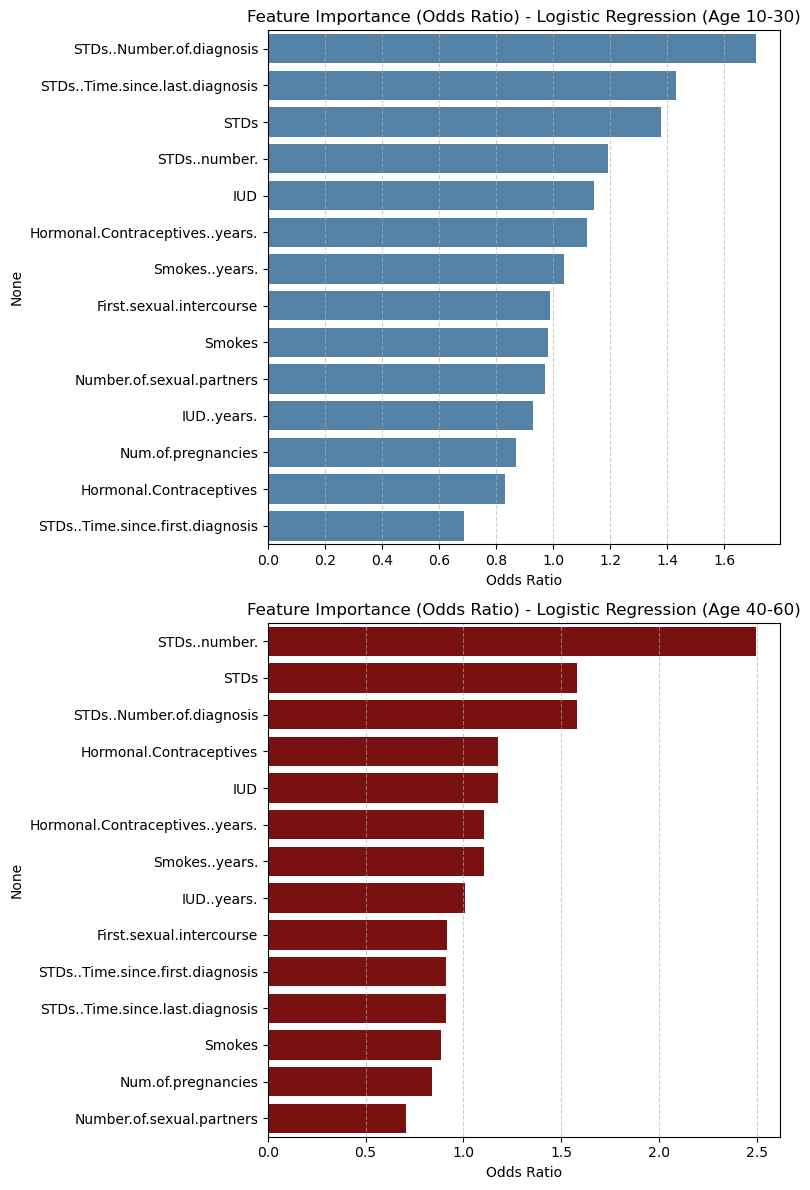

[LightGBM] [Info] Number of positive: 36, number of negative: 598
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 131
[LightGBM] [Info] Number of data points in the train set: 634, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.056782 -> initscore=-2.810072
[LightGBM] [Info] Start training from score -2.810072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


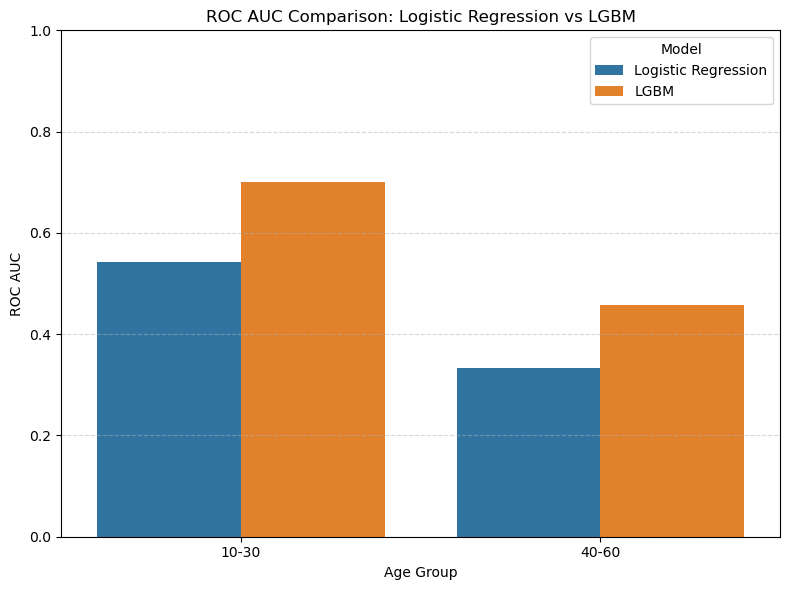

Age Group,Model,Accuracy,ROC AUC,주요 변수 (LGBM 기준)
10-30,Logistic Regression,0.918239,0.542940,-
40-60,Logistic Regression,0.846154,0.333333,-
10-30,LGBM,0.911950,0.701001,"Hormonal.Contraceptives..years., First.sexual.intercourse 등"
40-60,LGBM,0.923077,0.458333,"Hormonal.Contraceptives..years., Number.of.sexual.partners 등"


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from lightgbm import LGBMClassifier
from IPython.display import display, HTML

############################
# 1. 데이터 로드 및 전처리
############################

# 파일 경로 수정 (파일 재업로드 필요)
file_path = r"C:\001. Python\700. 설명가능인공지능_실습\cancer.csv"

# 데이터 로드
df_cancer = pd.read_csv(file_path, engine="python", encoding="utf-8")

# 연령대를 10대, 20대, 30대 / 40대, 50대, 60대로 구분
df_cancer["Age_Group"] = pd.cut(
    df_cancer["Age"],
    bins=[10, 19, 29, 39, 49, 59, 69],
    labels=["10대", "20대", "30대", "40대", "50대", "60대"]
)

# 10–30대 및 40–60대 데이터 추출 (Age와 Age_Group 열 제거)
df_cancer_10_30 = df_cancer[df_cancer["Age_Group"].isin(["10대", "20대", "30대"])].drop(columns=["Age", "Age_Group"])
df_cancer_40_60 = df_cancer[df_cancer["Age_Group"].isin(["40대", "50대", "60대"])].drop(columns=["Age", "Age_Group"])

# 독립변수(X)와 종속변수(y) 설정 (자궁암 여부: Biopsy)
X_10_30 = df_cancer_10_30.drop(columns=["Biopsy"])
y_10_30 = df_cancer_10_30["Biopsy"]

X_40_60 = df_cancer_40_60.drop(columns=["Biopsy"])
y_40_60 = df_cancer_40_60["Biopsy"]

# 데이터 분할 (훈련/테스트 세트)
X_train_10_30, X_test_10_30, y_train_10_30, y_test_10_30 = train_test_split(X_10_30, y_10_30, test_size=0.2, random_state=42)
X_train_40_60, X_test_40_60, y_train_40_60, y_test_40_60 = train_test_split(X_40_60, y_40_60, test_size=0.2, random_state=42)

##################################
# 2. Logistic Regression 모델
##################################

# 모델 생성 및 학습
logit_10_30 = LogisticRegression(max_iter=1000, random_state=42)
logit_40_60 = LogisticRegression(max_iter=1000, random_state=42)

logit_10_30.fit(X_train_10_30, y_train_10_30)
logit_40_60.fit(X_train_40_60, y_train_40_60)

# 예측 수행
y_pred_10_30 = logit_10_30.predict(X_test_10_30)
y_pred_40_60 = logit_40_60.predict(X_test_40_60)

# 성능 평가
accuracy_10_30 = accuracy_score(y_test_10_30, y_pred_10_30)
accuracy_40_60 = accuracy_score(y_test_40_60, y_pred_40_60)
roc_auc_10_30 = roc_auc_score(y_test_10_30, logit_10_30.predict_proba(X_test_10_30)[:, 1])
roc_auc_40_60 = roc_auc_score(y_test_40_60, logit_40_60.predict_proba(X_test_40_60)[:, 1])

# 회귀 계수 (Odds Ratio) 계산 및 정렬
coef_10_30 = pd.Series(np.exp(logit_10_30.coef_[0]), index=X_10_30.columns).sort_values(ascending=False)
coef_40_60 = pd.Series(np.exp(logit_40_60.coef_[0]), index=X_40_60.columns).sort_values(ascending=False)

# 시각화: Logistic Regression 주요 변수
fig, axes = plt.subplots(2, 1, figsize=(8, 12))
sns.barplot(x=coef_10_30.values, y=coef_10_30.index, ax=axes[0], color="steelblue")
axes[0].set_title("Feature Importance (Odds Ratio) - Logistic Regression (Age 10-30)")
axes[0].set_xlabel("Odds Ratio")
axes[0].grid(axis='x', linestyle="--", alpha=0.6)

sns.barplot(x=coef_40_60.values, y=coef_40_60.index, ax=axes[1], color="darkred")
axes[1].set_title("Feature Importance (Odds Ratio) - Logistic Regression (Age 40-60)")
axes[1].set_xlabel("Odds Ratio")
axes[1].grid(axis='x', linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Logistic Regression 성능 결과 DataFrame 생성
logit_results = pd.DataFrame({
    "Age Group": ["10-30", "40-60"],
    "Accuracy": [accuracy_10_30, accuracy_40_60],
    "ROC AUC": [roc_auc_10_30, roc_auc_40_60]
})
logit_results["주요 변수 (LGBM 기준)"] = ["-", "-"]

##################################
# 3. LGBM 모델 (Classifier)
##################################

# 모델 생성 및 학습
lgbm_10_30 = LGBMClassifier(random_state=42)
lgbm_40_60 = LGBMClassifier(random_state=42)

lgbm_10_30.fit(X_train_10_30, y_train_10_30)
lgbm_40_60.fit(X_train_40_60, y_train_40_60)

# 예측 및 평가
y_pred_lgbm_10_30 = lgbm_10_30.predict(X_test_10_30)
y_pred_lgbm_40_60 = lgbm_40_60.predict(X_test_40_60)

accuracy_lgbm_10_30 = accuracy_score(y_test_10_30, y_pred_lgbm_10_30)
accuracy_lgbm_40_60 = accuracy_score(y_test_40_60, y_pred_lgbm_40_60)
roc_auc_lgbm_10_30 = roc_auc_score(y_test_10_30, lgbm_10_30.predict_proba(X_test_10_30)[:, 1])
roc_auc_lgbm_40_60 = roc_auc_score(y_test_40_60, lgbm_40_60.predict_proba(X_test_40_60)[:, 1])

# LGBM 성능 결과 DataFrame 생성
lgbm_results = pd.DataFrame({
    "Age Group": ["10-30", "40-60"],
    "Accuracy": [accuracy_lgbm_10_30, accuracy_lgbm_40_60],
    "ROC AUC": [roc_auc_lgbm_10_30, roc_auc_lgbm_40_60]
})

# LGBM의 주요 변수(중요도 기준 상위 2개) 동적 산출
feat_imp_10_30 = pd.Series(lgbm_10_30.feature_importances_, index=X_10_30.columns).sort_values(ascending=False)
top_feats_10_30 = ", ".join(feat_imp_10_30.index[:2]) + " 등"

feat_imp_40_60 = pd.Series(lgbm_40_60.feature_importances_, index=X_40_60.columns).sort_values(ascending=False)
top_feats_40_60 = ", ".join(feat_imp_40_60.index[:2]) + " 등"

lgbm_results["주요 변수 (LGBM 기준)"] = [top_feats_10_30, top_feats_40_60]

##################################
# 4. 성능 결과 비교 테이블 생성 및 출력
##################################

# 두 모델의 결과를 합침
comparison = pd.concat([
    logit_results.assign(Model="Logistic Regression"),
    lgbm_results.assign(Model="LGBM")
])

# 컬럼 순서 재정렬
comparison = comparison[["Age Group", "Model", "Accuracy", "ROC AUC", "주요 변수 (LGBM 기준)"]]

# 인덱스 초기화 (non-unique index 문제 해결)
comparison = comparison.reset_index(drop=True)

# 성능 결과 비교 Bar Chart (ROC AUC 기준)
plt.figure(figsize=(8, 6))
sns.barplot(data=comparison, x="Age Group", y="ROC AUC", hue="Model")
plt.title("ROC AUC Comparison: Logistic Regression vs LGBM")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# HTML 스타일 표로 예쁘게 출력 (Jupyter Notebook 등에서 실행 시)
styled_table = comparison.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f8f9fa'),
                                   ('font-weight', 'bold'),
                                   ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
]).set_properties(**{
    'padding': '8px',
    'border': '1px solid #ddd'
}).hide(axis='index')

display(HTML(styled_table.to_html()))


4. 3에서 만들어진 Logistic regression, LGBM 모델 결과를 해석하여 (LR은 coefficient 해석, LGBM은 SHAP 방법으로 해석) 예측에 가장 큰 영향을 미치는 독립변수는 무엇인지 비교하세요.

10-30대 Logistic Regression Odds Ratios:
STDs..Number.of.diagnosis          1.709326
STDs..Time.since.last.diagnosis    1.431273
STDs                               1.377457
dtype: float64


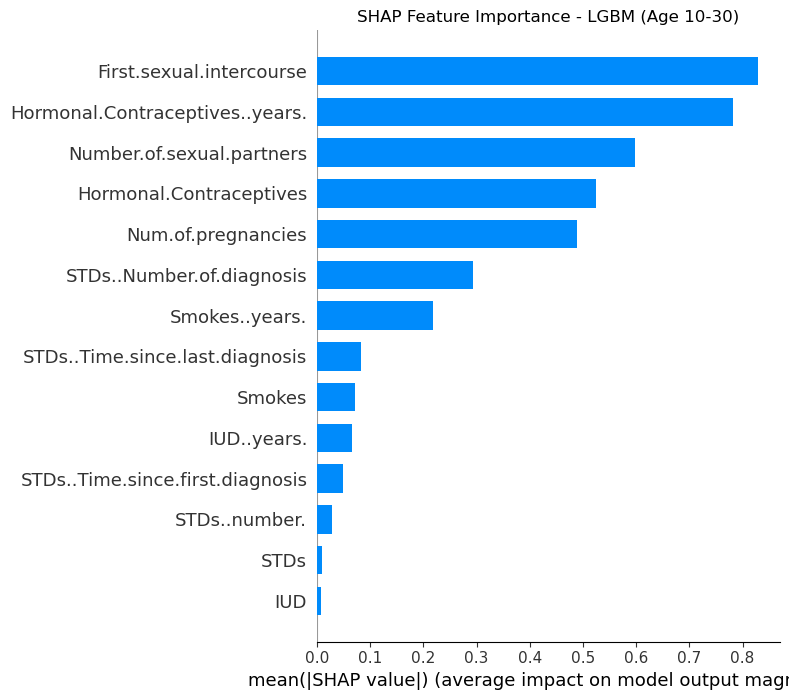

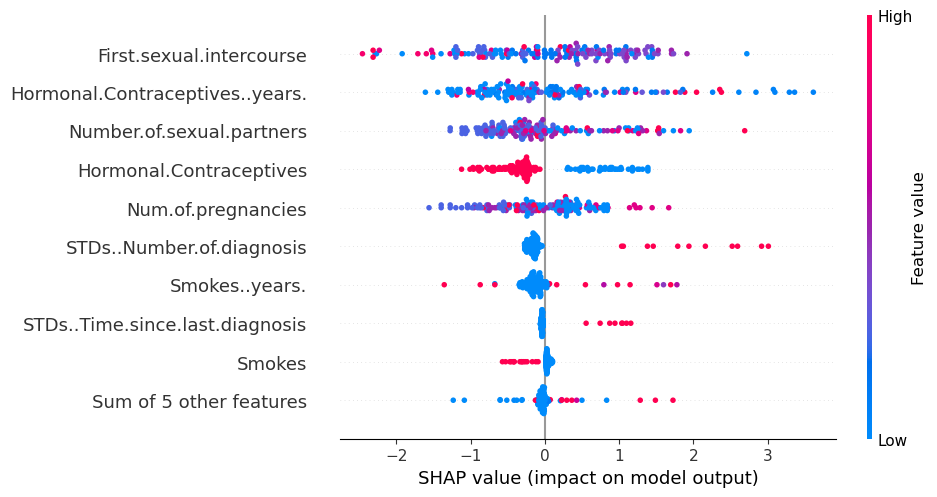

40-60대 Logistic Regression Odds Ratios:
STDs..number.                2.49280
STDs                         1.57886
STDs..Number.of.diagnosis    1.57886
dtype: float64


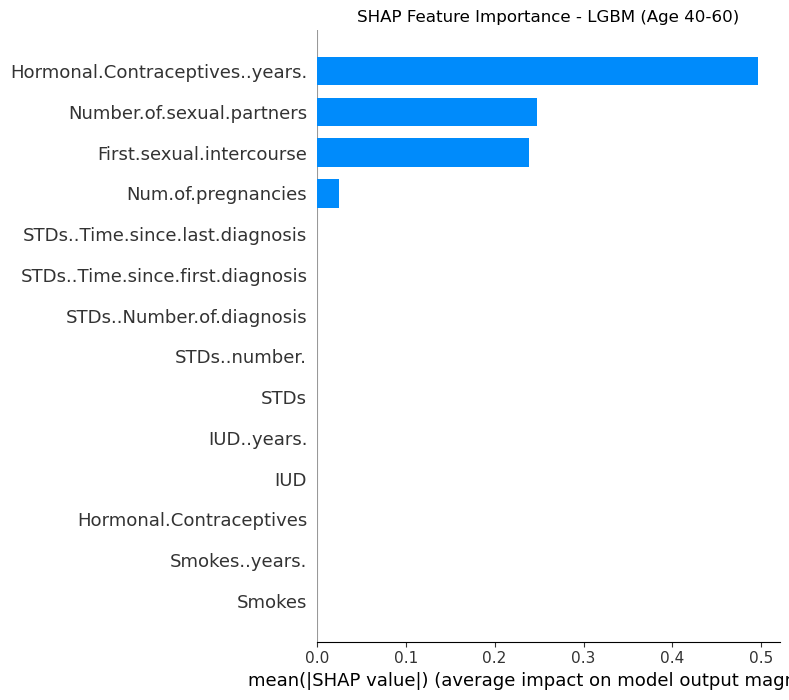

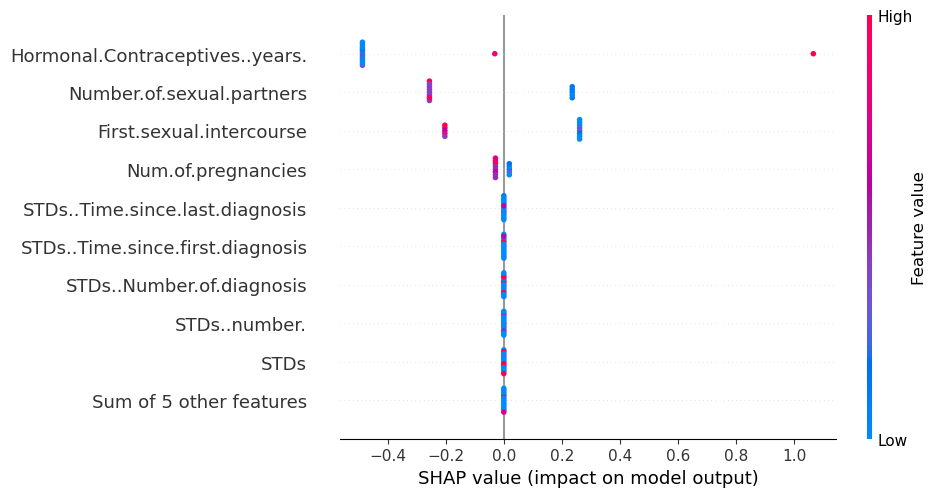


[결과 요약]
10-30대:
 - Logistic Regression: 가장 큰 영향력을 가진 변수 -> STDs..Number.of.diagnosis
 - LGBM (SHAP): SHAP summary plot에서 최상위 변수 확인

40-60대:
 - Logistic Regression: 가장 큰 영향력을 가진 변수 -> STDs..number.
 - LGBM (SHAP): SHAP summary plot에서 최상위 변수 확인


In [ ]:
import shap
import matplotlib.pyplot as plt

# === 1. Logistic Regression 결과 해석 (예: 10-30대) ===

# 이미 계산된 LR odds ratio(coef_10_30)를 확인하면,
print("10-30대 Logistic Regression Odds Ratios:")
print(coef_10_30.head(3))

# === 2. LGBM SHAP 해석 (예: 10-30대) ===

# SHAP 설명자 생성 (LGBM 모델)
explainer_10_30 = shap.Explainer(lgbm_10_30)
shap_values_10_30 = explainer_10_30(X_test_10_30)

# SHAP summary plot (bar plot 형태)
shap.summary_plot(shap_values_10_30, X_test_10_30, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - LGBM (Age 10-30)")
plt.tight_layout()
plt.show()

explainer = shap.TreeExplainer(lgbm_10_30)
shap_values = explainer(X_test_10_30) 

shap.plots.beeswarm(shap_values)

# === 3. 동일 방식으로 40-60대 모델에 대해서도 해석 ===

# Logistic Regression (40-60대)
print("40-60대 Logistic Regression Odds Ratios:")
print(coef_40_60.head(3))

# LGBM SHAP 해석 (40-60대)
explainer_40_60 = shap.Explainer(lgbm_40_60)
shap_values_40_60 = explainer_40_60(X_test_40_60)

shap.summary_plot(shap_values_40_60, X_test_40_60, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - LGBM (Age 40-60)")
plt.tight_layout()
plt.show()

explainer = shap.TreeExplainer(lgbm_40_60)
shap_values = explainer(X_test_40_60) 

shap.plots.beeswarm(shap_values)


# === 4. 결과 비교 요약 ===
print("\n[결과 요약]")
print("10-30대:")
print(" - Logistic Regression: 가장 큰 영향력을 가진 변수 ->", coef_10_30.idxmax())
print(" - LGBM (SHAP): SHAP summary plot에서 최상위 변수 확인")

print("\n40-60대:")
print(" - Logistic Regression: 가장 큰 영향력을 가진 변수 ->", coef_40_60.idxmax())
print(" - LGBM (SHAP): SHAP summary plot에서 최상위 변수 확인")

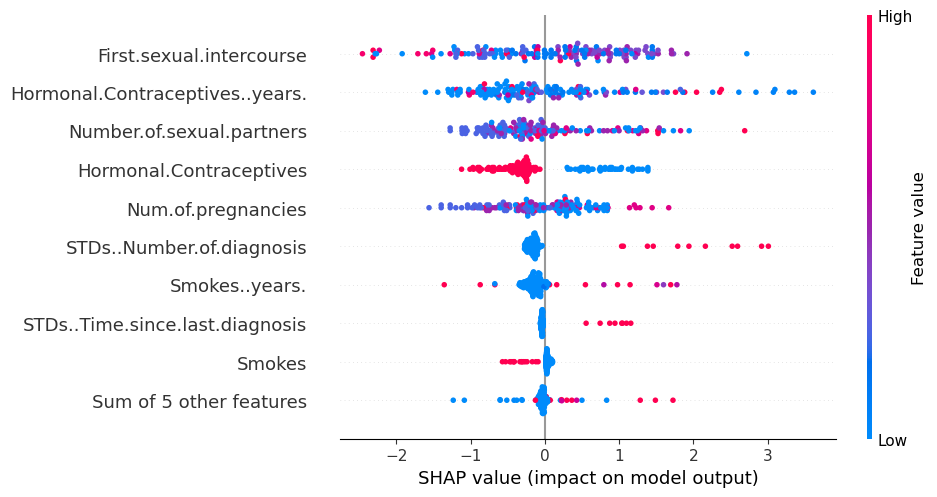

In [ ]:
# SHAP value 10-30대
import shap

explainer = shap.TreeExplainer(lgbm_10_30)
shap_values = explainer(X_test_10_30) 

shap.plots.beeswarm(shap_values)

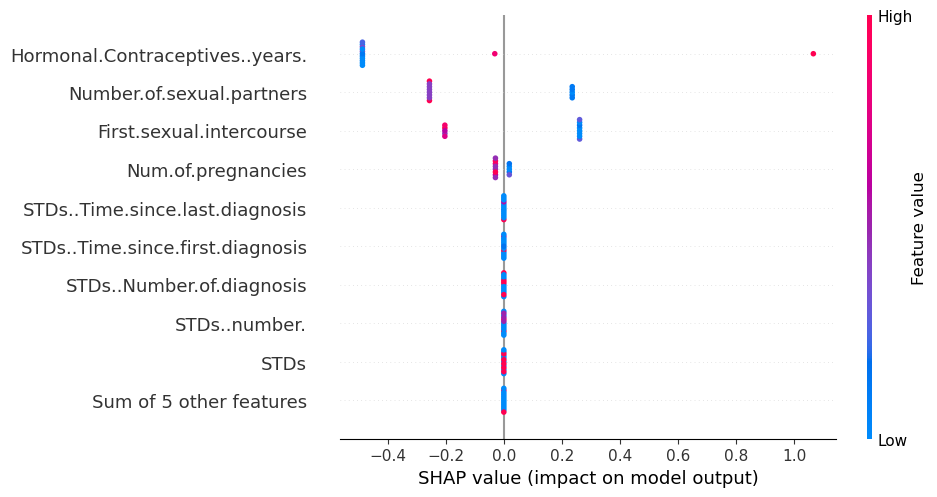

In [9]:
# SHAP value 10-30대
import shap

explainer = shap.TreeExplainer(lgbm_40_60)
shap_values = explainer(X_test_40_60) 

shap.plots.beeswarm(shap_values)

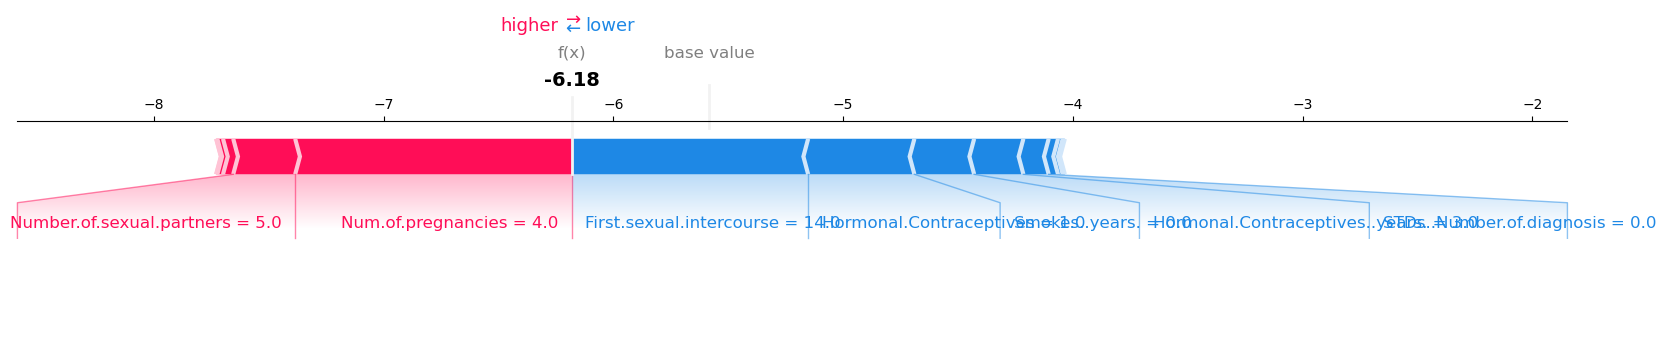

In [20]:
import shap
import matplotlib.pyplot as plt

# ---------------------------------------------------
# 10~30대 대상 모델의 SHAP 값 계산
# TreeExplainer는 LGBM 모델에 적합
# ---------------------------------------------------
explainer_10_30 = shap.Explainer(lgbm_10_30)
shap_values_10_30 = explainer_10_30(X_test_10_30)

# ---------------------------------------------------
# SHAP Force Plot - 첫 번째 테스트 샘플
# Explanation 객체이므로 바로 사용 가능
# ---------------------------------------------------
shap.force_plot(
    base_value=shap_values_10_30.base_values[0],  # 첫 샘플의 baseline
    shap_values=shap_values_10_30.values[0],      # 첫 샘플의 SHAP 값
    features=X_test_10_30.iloc[0, :],             # 해당 샘플의 특성값
    feature_names=X_test_10_30.columns,           # 특성 이름
    matplotlib=True
)


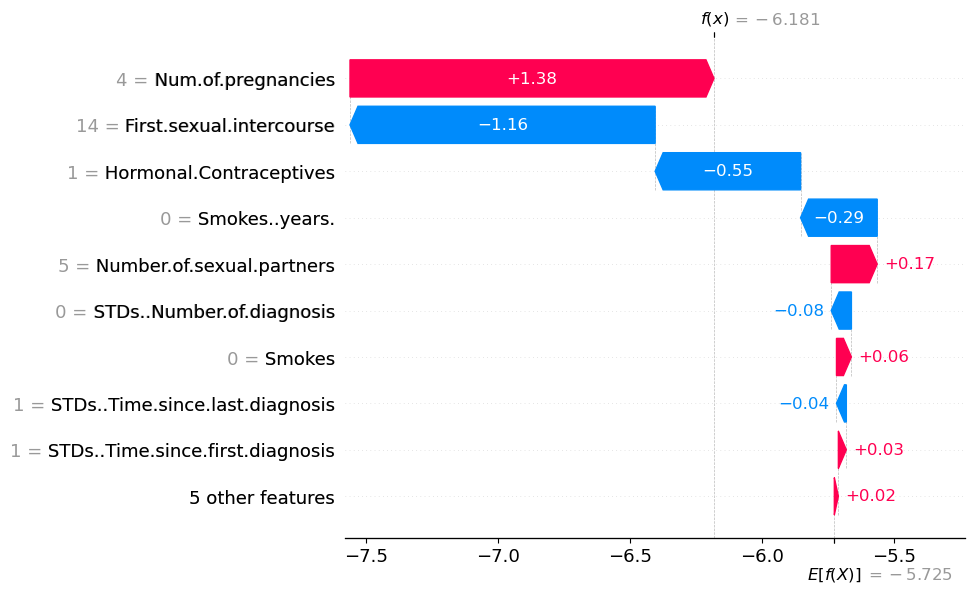

In [21]:
import shap

# ---------------------------------------------------
# 10–30대 LGBM 모델 SHAP waterfall plot
# ---------------------------------------------------
explainer_10_30 = shap.Explainer(lgbm_10_30, X_train_10_30)
shap_values_10_30 = explainer_10_30(X_test_10_30)

# 첫 번째 테스트 샘플에 대해 waterfall plot 출력
shap.plots.waterfall(shap_values_10_30[0])


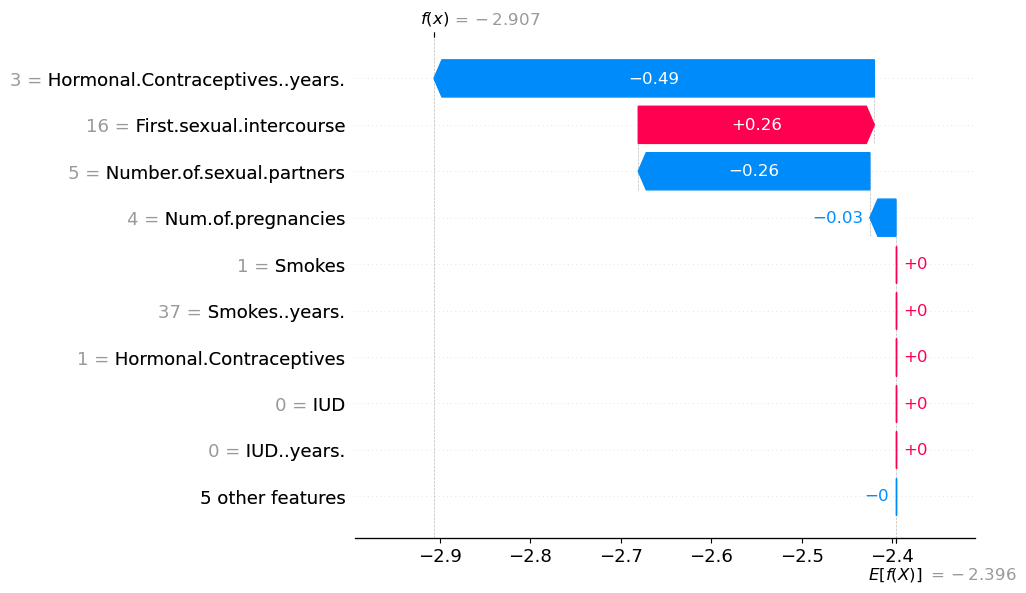

In [22]:
# ---------------------------------------------------
# 40–60대 LGBM 모델 SHAP waterfall plot
# ---------------------------------------------------
explainer_40_60 = shap.Explainer(lgbm_40_60, X_train_40_60)
shap_values_40_60 = explainer_40_60(X_test_40_60)

# 첫 번째 테스트 샘플에 대해 waterfall plot 출력
shap.plots.waterfall(shap_values_40_60[0])
